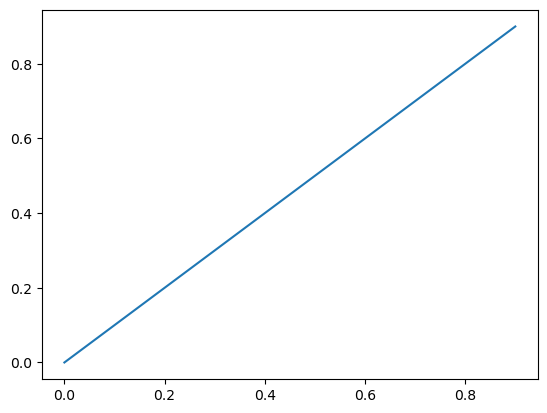

In [30]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,1,0.1)
plt.figure()
plt.plot(x,x)
plt.show()

In [37]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms import made
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
from NFconstants import N_nod, Beta, a
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C

def set_random_seed(seed):
    torch.manual_seed(seed)
    
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)
print(N_nod)





False
64


In [186]:
num_layers = 2
base_dist = StandardNormal(shape=[N_nod])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=N_nod))
    transforms.append(MaskedAffineAutoregressiveTransform(features=N_nod, 
                                                          hidden_features=2*N_nod,
                                                          use_batch_norm=True,
                                                          use_residual_blocks=True))
transform = CompositeTransform(transforms)
flow = Flow(transform, base_dist)

In [187]:
print(transform)

CompositeTransform(
  (_transforms): ModuleList(
    (0): ReversePermutation()
    (1): MaskedAffineAutoregressiveTransform(
      (autoregressive_net): MADE(
        (initial_layer): MaskedLinear(in_features=64, out_features=128, bias=True)
        (blocks): ModuleList(
          (0-1): 2 x MaskedResidualBlock(
            (batch_norm_layers): ModuleList(
              (0-1): 2 x BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            )
            (linear_layers): ModuleList(
              (0-1): 2 x MaskedLinear(in_features=128, out_features=128, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (final_layer): MaskedLinear(in_features=128, out_features=128, bias=True)
      )
    )
    (2): ReversePermutation()
    (3): MaskedAffineAutoregressiveTransform(
      (autoregressive_net): MADE(
        (initial_layer): MaskedLinear(in_features=64, out_features=128, bias=True)
        (blocks): 

In [188]:
MAT=MaskedAffineAutoregressiveTransform(features=N_nod,hidden_features=N_nod,use_batch_norm=True,use_residual_blocks=False)
print(MAT.autoregressive_net)

MADE(
  (initial_layer): MaskedLinear(in_features=64, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (final_layer): MaskedLinear(in_features=64, out_features=128, bias=True)
)


In [189]:
made_model = made.MADE(
            features=N_nod//2,
            hidden_features=N_nod,
            num_blocks=4,
            output_multiplier = 2,
            use_residual_blocks=False,
            random_mask=True,
            activation=F.leaky_relu,
            dropout_probability=0.0,
            use_batch_norm=True)

In [190]:
print(made_model)

MADE(
  (initial_layer): MaskedLinear(in_features=32, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (final_layer): MaskedLinear(in_features=64, out_features=64, bias=True)
)


In [191]:
z = normal_dist.sample((10,))
print(z[:,::2].shape)
autoregressive_params = made_model(z[:,::2])
autoregressive_params = autoregressive_params.view(-1, N_nod//2, 2)
unconstrained_scale = autoregressive_params[..., 0]
shift = autoregressive_params[..., 1]
print(shift.shape)

torch.Size([10, 32])
torch.Size([10, 32])


In [192]:
z = normal_dist.sample((10,))
print(z.shape)
z = base_dist.sample(10)
print(z.shape)
w,_ = MAT(z)
print(w.shape)

torch.Size([10, 64])
torch.Size([10, 64])
torch.Size([10, 64])


In [201]:
class Pipeline_lib(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, log_abs_det = self.model.sample_and_log_prob(2**6)
        x = torch.matmul(x,Ot.to(x.device))
        delta=N_nod//2*(1+torch.log( 2 * torch.tensor(np.pi)))
        #print(delta.requires_grad)
        loss = self.loss(x,-log_abs_det)+delta
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    

In [202]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()
KL_mat_osc=osc.get_mat_KL()
KL_rel001=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=0.01)
KL_rel01=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=0.1)
KL_rel1=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=1)
KL_rel10=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=10)
KL_ur=Ur_Oscillator.make_KL(Ur_Oscillator,N_nod,Beta)

KL_rel29=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma = 2 ** 9)

KL_X4=X4.make_KL(X4,N_nod,Beta,g=0.05)
KL_morse=Morse.make_KL(Morse,N_nod,Beta,alpha=1)
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()

KL_rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()

In [203]:
#flow.load_state_dict(torch.load('model_weights1.pth'))

In [204]:
from Data import train_loader

set_random_seed(42)
pipeline = Pipeline_lib(model=flow, criterion=KL_ur, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs=50,
    logger=TensorBoardLogger(save_dir = f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(flow.state_dict(), "model_weights3.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | Flow      | 183 K 
1 | loss  | KL_with_S | 0     
------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.


In [205]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
set_random_seed(42)
NF_trained = flow
NF_trained.load_state_dict(torch.load('model_weights3.pth'))
NF_trained.eval()
print("start")
trajs = NF_trained.sample(100)
trajs=torch.matmul(trajs,Ot.to(trajs.device))

start


In [206]:
from NFandist import get_T
def G(X,n_p=N_nod):
    n_nod=(X.shape)[1]
    n_traj=(X.shape)[0]
    T=torch.tensor(get_T(n_nod)).float()
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(n_traj*n_nod)
g_nf=G(trajs)

In [15]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [31]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [32]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [207]:
g_ur = np.genfromtxt("g_ur N=256 Beta=16")

In [ ]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [16]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [ ]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [ ]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.3675651931762695


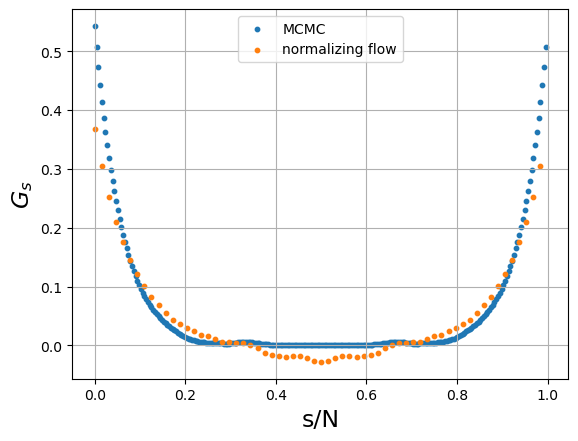

In [208]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta



g=g_ur
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g_ur,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.xlabel(r"s/N",fontsize=17)
plt.ylabel(r"$G_s$",fontsize=17)
plt.legend(["MCMC","normalizing flow"])
plt.grid(True)
plt.show()


In [26]:
K = (1 - 2 * (g_nf[0]-g_nf[1]) / a) / (2 * a)
print(K)
V2=g_nf[0]/2
print((3/2)*K+(1/2)*V2)

0.16764257812500105
0.6877026062011735


In [2]:


! du -sh logs






1.6G	logs


In [3]:
! rm -rf logs
